In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import random
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tqdm import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
img_size = (224, 224)

In [4]:
datadir = '/content/drive/MyDrive/ml project/pneumonia/train'
categories = ['normal', 'pneumonia']
train = []

for category in categories:
  path = os.path.join(datadir, category)
  class_num = categories.index(category)
  for img in tqdm(os.listdir(path)):
    img_array = cv2.imread(os.path.join(path,img))
    new_array = cv2.resize(img_array, img_size)
    train.append([new_array, class_num])

100%|██████████| 3878/3878 [03:42<00:00, 17.43it/s]


In [5]:
random.shuffle(train)

In [6]:
X_train = []
y_train = []

for features, labels in tqdm(train):
  X_train.append(features)
  y_train.append(labels)

X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 5219/5219 [00:00<00:00, 922852.98it/s]


In [7]:
import gc
del train
gc.collect()

43

In [8]:
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)

X_train:  (5219, 224, 224, 3)
y_train:  (5219,)


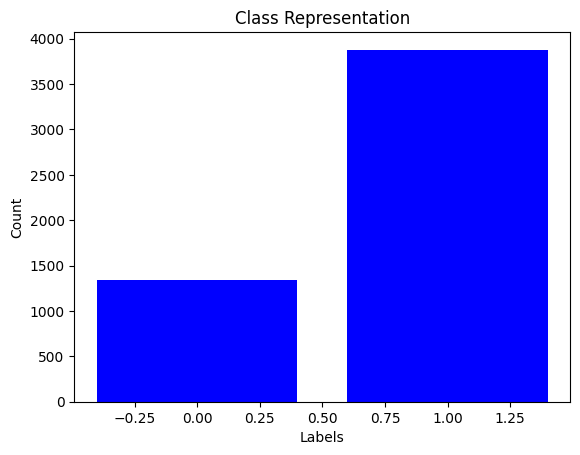

In [9]:
unique_labels, counts = np.unique(y_train, return_counts=True)

# Create a bar chart
plt.bar(unique_labels, counts, color='blue')

# Add labels and title
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Class Representation')

# Show the plot
plt.show()

In [10]:
datadir = '/content/drive/MyDrive/ml project/pneumonia/val'
categories = ['normal', 'pneumonia']
val = []

for category in categories:
  path = os.path.join(datadir, category)
  class_num = categories.index(category)
  for img in tqdm(os.listdir(path)):
    img_array = cv2.imread(os.path.join(path,img))
    new_array = cv2.resize(img_array, img_size)
    val.append([new_array, class_num])

100%|██████████| 8/8 [00:02<00:00,  3.40it/s]


In [11]:
random.shuffle(val)

In [12]:
X_val = []
y_val = []

for features, labels in tqdm(val):
  X_val.append(features)
  y_val.append(labels)

X_val = np.array(X_val)
y_val = np.array(y_val)

100%|██████████| 16/16 [00:00<00:00, 119410.79it/s]


In [13]:
print("X_val: ", X_val.shape)
print("y_val: ", y_val.shape)

X_val:  (16, 224, 224, 3)
y_val:  (16,)


In [14]:
import gc
del val
gc.collect()

3628

In [15]:
datadir = '/content/drive/MyDrive/ml project/pneumonia/test'
categories = ['normal', 'pneumonia']
test = []

for category in categories:
  path = os.path.join(datadir, category)
  class_num = categories.index(category)
  for img in tqdm(os.listdir(path)):
    img_array = cv2.imread(os.path.join(path,img))
    new_array = cv2.resize(img_array, img_size)
    test.append([new_array, class_num])

100%|██████████| 399/399 [00:13<00:00, 30.18it/s]


In [16]:
random.shuffle(test)

In [17]:
X_test = []
y_test = []

for features, labels in tqdm(test):
  X_test.append(features)
  y_test.append(labels)

X_test = np.array(X_test)
y_test = np.array(y_test)

100%|██████████| 633/633 [00:00<00:00, 429610.75it/s]


In [18]:
print("X_test: ", X_test.shape)
print("y_test: ", y_test.shape)

X_test:  (633, 224, 224, 3)
y_test:  (633,)


In [19]:
import gc
del test
gc.collect()

0

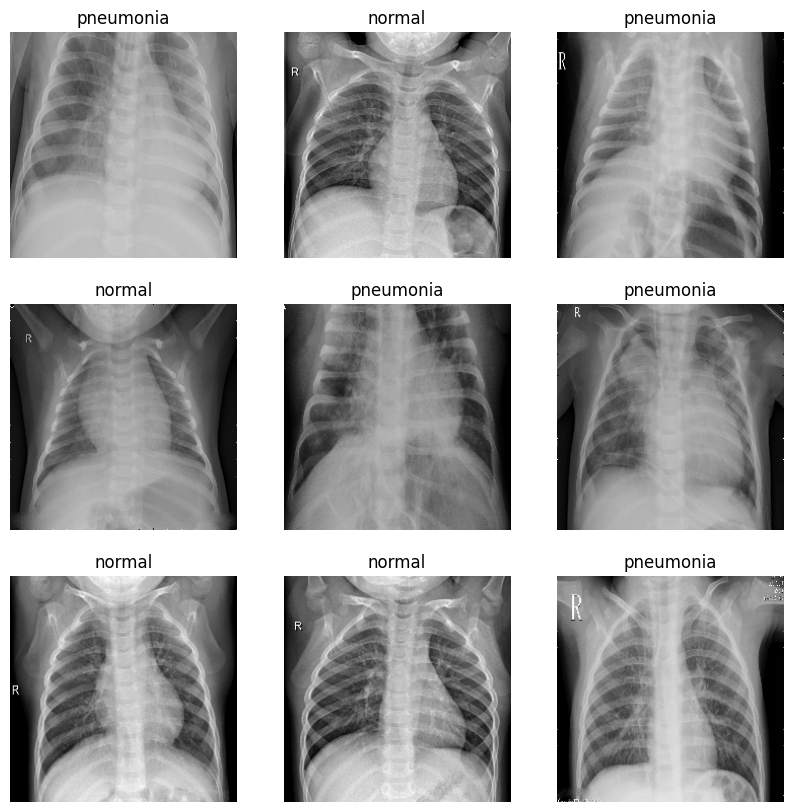

In [20]:
plt.figure(figsize = (10,10))
for i in range(9):
  ax = plt.subplot(3,3,i+1)
  plt.imshow(X_train[i], cmap = 'gray')
  plt.title(categories[y_train[i]])
  plt.axis('off')

In [21]:
base_model = MobileNetV3Small(weights='imagenet', include_top = False, input_shape = X_train[0].shape, pooling='average', classes=5)
base_model.trainable = False

4334752/4334752 [==============================] - 0s 0us/step


In [22]:
# X_train = preprocess_input(X_train)
# X_test = preprocess_input(X_test)

In [23]:
base_model.summary()

Model: "MobilenetV3small"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 Conv (Conv2D)               (None, 112, 112, 16)         432       ['rescaling[0][0]']           
                                                                                                  
 Conv/BatchNorm (BatchNorma  (None, 112, 112, 16)         64        ['Conv[0][0]']                
 lization)                                                                         

In [24]:
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation = 'relu')
dense_layer_2 = layers.Dense(10, activation = 'relu')
prediction_layer = layers.Dense(1, activation = 'sigmoid')

model = models.Sequential([base_model,
                           flatten_layer,
                           dense_layer_1,
                           dense_layer_2,
                           prediction_layer])

In [25]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight = "balanced",
                                        classes = np.unique(y_train),
                                        y = y_train)
class_weights = dict(zip(np.unique(y_train), class_weights))
class_weights

{0: 1.9459358687546606, 1: 0.6728984012377515}

In [28]:
import datetime

opt = tf.keras.optimizers.Adam(learning_rate=0.005)
model.compile(optimizer = opt,
              loss = 'binary_crossentropy',
              metrics = ['accuracy'],)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
callback = []
es = EarlyStopping(monitor = 'val_accuracy', mode = 'auto', patience = 5, restore_best_weights = True)
callback.append(tensorboard_callback)
callback.append(es)
hist = model.fit(X_train, y_train, epochs = 10, batch_size=8, callbacks=callback, validation_data=(X_val, y_val), validation_batch_size=2, shuffle=True, class_weight=class_weights)

Epoch 1/10
653/653 [==============================] - 79s 115ms/step - loss: 0.1898 - accuracy: 0.9680 - val_loss: 0.0170 - val_accuracy: 1.0000
Epoch 2/10
653/653 [==============================] - 72s 110ms/step - loss: 0.0841 - accuracy: 0.9839 - val_loss: 0.0409 - val_accuracy: 1.0000
Epoch 3/10
653/653 [==============================] - 78s 120ms/step - loss: 0.0351 - accuracy: 0.9937 - val_loss: 0.0172 - val_accuracy: 1.0000
Epoch 4/10
653/653 [==============================] - 75s 115ms/step - loss: 0.0228 - accuracy: 0.9943 - val_loss: 0.1339 - val_accuracy: 0.9375
Epoch 5/10
653/653 [==============================] - 72s 111ms/step - loss: 0.0361 - accuracy: 0.9927 - val_loss: 0.0027 - val_accuracy: 1.0000
Epoch 6/10
653/653 [==============================] - 71s 109ms/step - loss: 0.0417 - accuracy: 0.9921 - val_loss: 0.0280 - val_accuracy: 1.0000


In [ ]:
model.save('/content/drive/MyDrive/ml project/pneumonia/mobilenetv3.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


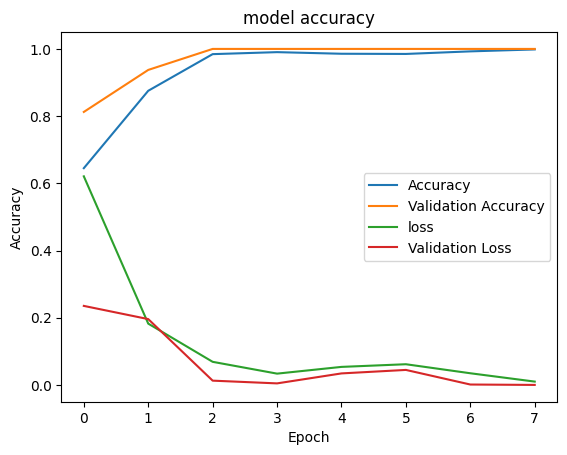

In [ ]:
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

In [ ]:
y_pred = model.predict(X_test)

20/20 [==============================] - 3s 60ms/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
y_pred = y_pred.reshape(-1)
y_pred.shape

(633,)

In [ ]:
for i in range(y_pred.shape[0]):
  if y_pred[i]>0.75:
    y_pred[i] = 1
  else:
    y_pred[i] = 0

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.89      0.79      0.84       234
           1       0.88      0.94      0.91       399

    accuracy                           0.89       633
   macro avg       0.89      0.87      0.87       633
weighted avg       0.89      0.89      0.88       633



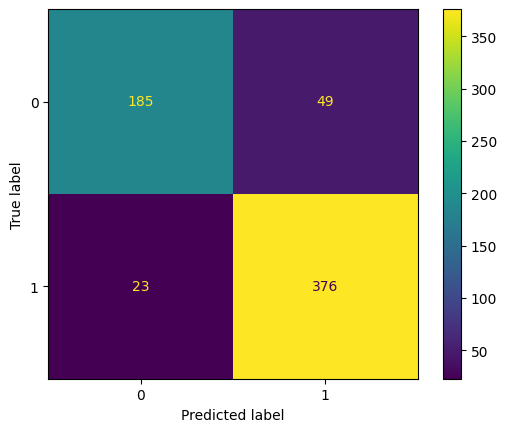

In [ ]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()